In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def get_cohorts(df, step=5, func=None, cumulative=False):
    results = []
    max_nb_ratings = df['nb_train_ratings'].max()
    start, end = 0, step
    while end < max_nb_ratings:
        mask = (df['nb_train_ratings'] >= start) & (df['nb_train_ratings'] < end)
        df_cohort = df.loc[mask]
        cohort_result = func(df_cohort) if func else df_cohort
        results.append(cohort_result)
        if not cumulative:
            start += step
        end += step
    return results

def get_user_cohorts(df_train, step=5, cumulative=False):
    df_train = df_train.groupby('user_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_ratings'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def get_movie_cohorts(df_train, step=5, cumulative=False):
    df_train = df_train.groupby('movie_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_ratings'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def plot_user_cohort_distribution(df_train, step=5):
    print "Cohort 0: users who have 0-5 training ratings"
    print "Cohort 1: users who have 5-10 training ratings"
    
    user_cohorts = get_user_cohorts(df_train, step=step)
    nb_users_per_cohort = map(lambda df: len(df), user_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of users')
    ax.set_xlabel('cohort (users)')
    ax.plot(xrange(len(nb_users_per_cohort)),nb_users_per_cohort, 'b')
    
    cumulative_users = np.cumsum(nb_users_per_cohort, dtype=np.float)
    cumulative_users /= cumulative_users[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of users')
    ax.set_xlabel('users that have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_users))]
    ax.plot(x_axis,cumulative_users, 'b')
    
def plot_movie_cohort_distribution(df_train, step=5):
    print "Cohort 0: movies who have 0-5 training ratings"
    print "Cohort 1: movies who have 5-10 training ratings"
    
    movie_cohorts = get_movie_cohorts(df_train, step=step)
    nb_movies_per_cohort = map(lambda df: len(df), movie_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of movies')
    ax.set_xlabel('cohort (movie)')
    ax.plot(xrange(len(nb_movies_per_cohort)),nb_movies_per_cohort, 'b')
    
    cumulative_movies = np.cumsum(nb_movies_per_cohort, dtype=np.float)
    cumulative_movies /= cumulative_movies[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of movies')
    ax.set_xlabel('movies that have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_movies))]
    ax.plot(x_axis,cumulative_movies, 'b')

def compare_metric(model1_metrics, model2_metrics, metric_name, step=5, cumulative=False, label1='MPCFs', label2='MPCFs-SI', nb_cohorts=None):
    func = lambda df: df[metric_name].mean()
    
    model1_metric_per_cohort = get_cohorts(model1_metrics, step=step, func=func, cumulative=cumulative)
    model2_metric_per_cohort = get_cohorts(model2_metrics, step=step, func=func, cumulative=cumulative)
    
    if nb_cohorts:
        model1_metric_per_cohort = model1_metric_per_cohort[:nb_cohorts]
        model2_metric_per_cohort = model2_metric_per_cohort[:nb_cohorts]
        
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_ylabel('Avg {}'.format(metric_name))
    if cumulative:
        ax.set_xlabel('users that have x or less training ratings')
        x_axis = [(i) * step for i in xrange(len(model1_metric_per_cohort))]
    else:
        ax.set_xlabel('cohort')
        x_axis = [i for i in xrange(len(model1_metric_per_cohort))]
    #assert len(model1_metric_per_cohort) == len(model2_metric_per_cohort)

    ax.plot(x_axis, model1_metric_per_cohort, 'r', label=label1)
    ax.plot(x_axis, model2_metric_per_cohort, 'g', label=label2)
    ax.legend(loc='upper right')
    
    print "avg {} for {} model:\t".format(metric_name, label1), model1_metrics[metric_name].mean()
    print "avg {} for {} model:\t".format(metric_name, label2), model2_metrics[metric_name].mean()
    
    return fig

In [28]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_user-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_user-metrics.csv')

avg auc for MPCFs model:	0.935918221087
avg auc for MPCFs-SI model:	0.937411280163


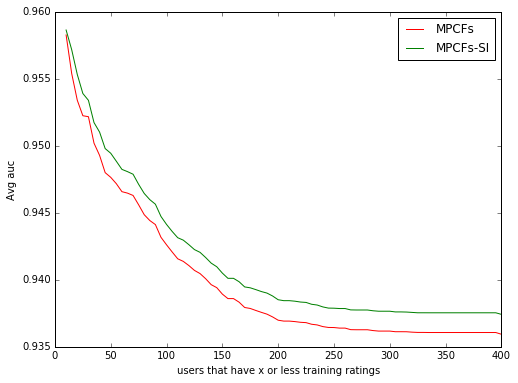

In [31]:
compare_metric(mpcf_metrics, mpcf_si_metrics,'auc', step=5,cumulative=True, nb_cohorts=None)

avg auc for MPCFs model:	0.87200724315
avg auc for MPCFs-SI model:	0.873320369661


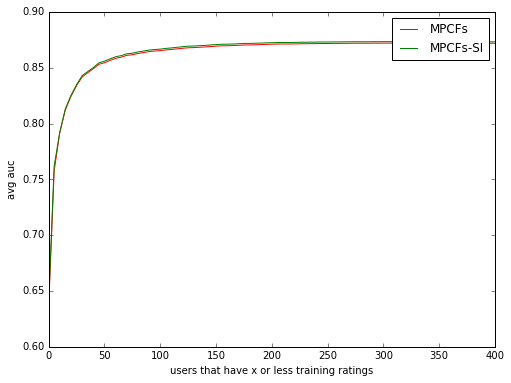

In [33]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_movie-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_movie-metrics.csv')
compare_metric(mpcf_metrics, mpcf_si_metrics,'auc', step=5,cumulative=True)

In [32]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-29_13.23.36_si_ml-1m_e20_tt-0.7_task-0_user-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-05-27_20.57.43_no-si_ml-1m_e20_tt-0.7_task-22_user-metrics.csv')

avg auc for MPCFs model:	0.928741575437
avg auc for MPCFs-SI model:	0.92898763495


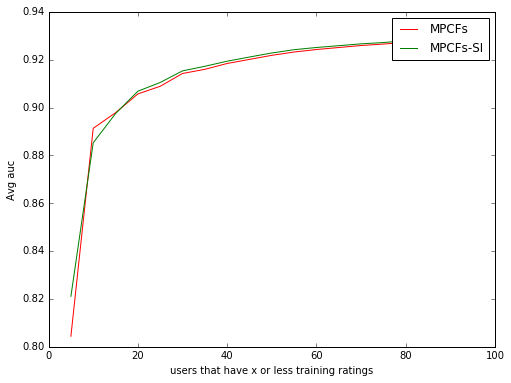

In [33]:
compare_metric(mpcf_metrics, mpcf_si_metrics,'auc', step=5,cumulative=True, nb_cohorts=20)

avg auc for MPCFs model:	0.911829743507
avg auc for MPCFs-SI model:	0.912854315933


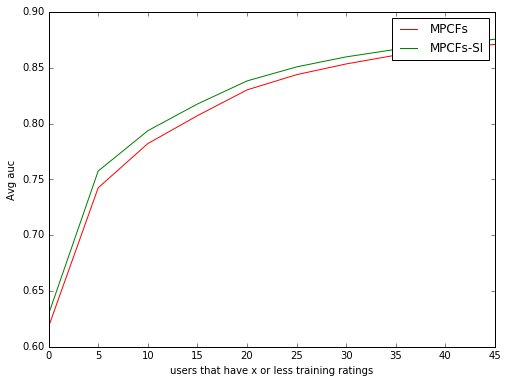

In [27]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-29_13.23.36_si_ml-1m_e20_tt-0.7_task-0_movie-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-05-27_20.57.43_no-si_ml-1m_e20_tt-0.7_task-22_movie-metrics.csv')
compare_metric(mpcf_metrics, mpcf_si_metrics,'auc', step=5,cumulative=True, nb_cohorts=10)

Cohort 0: users who have 0-5 training ratings
Cohort 1: users who have 5-10 training ratings
Cohort 0: movies who have 0-5 training ratings
Cohort 1: movies who have 5-10 training ratings


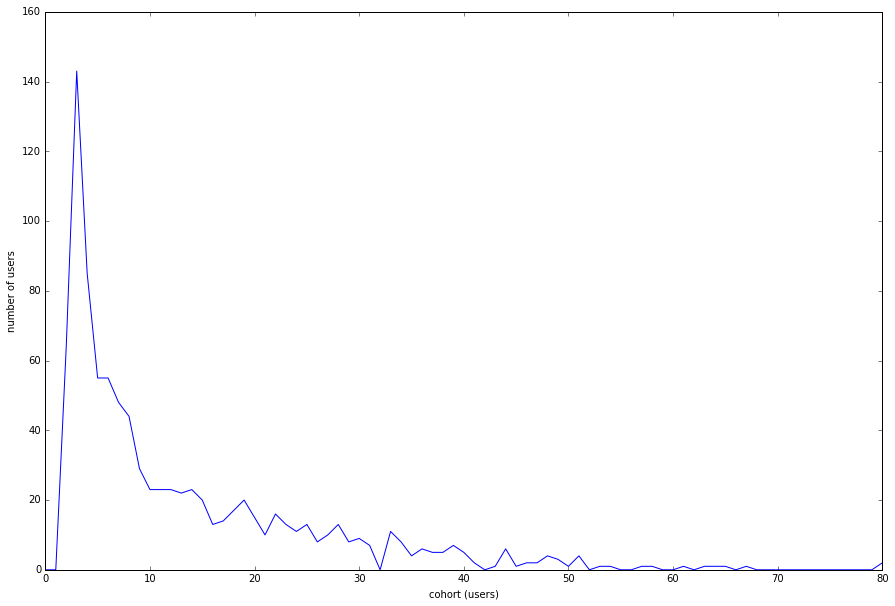

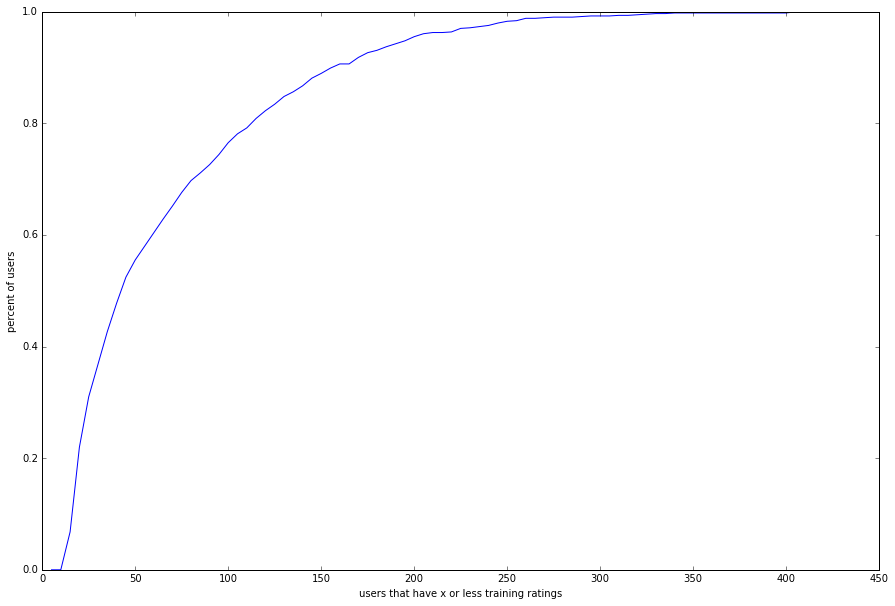

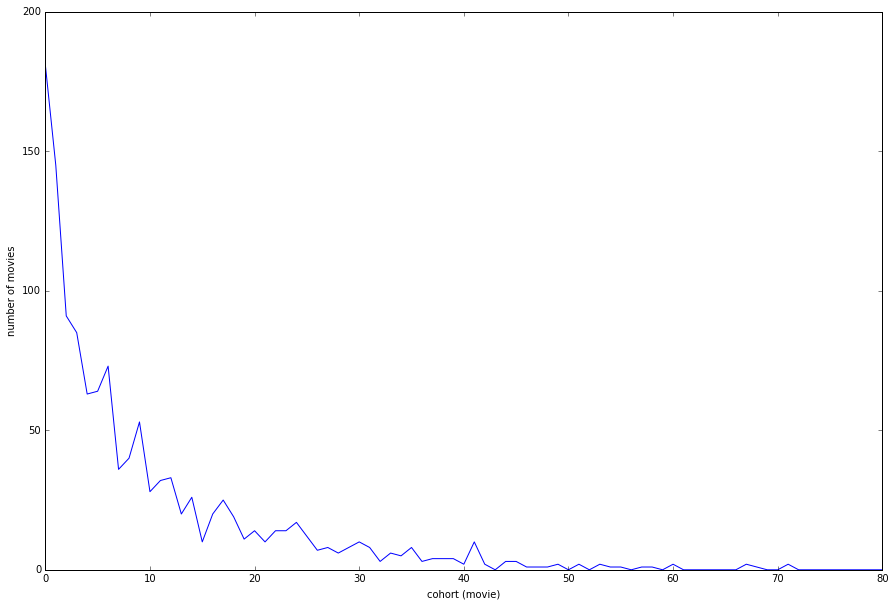

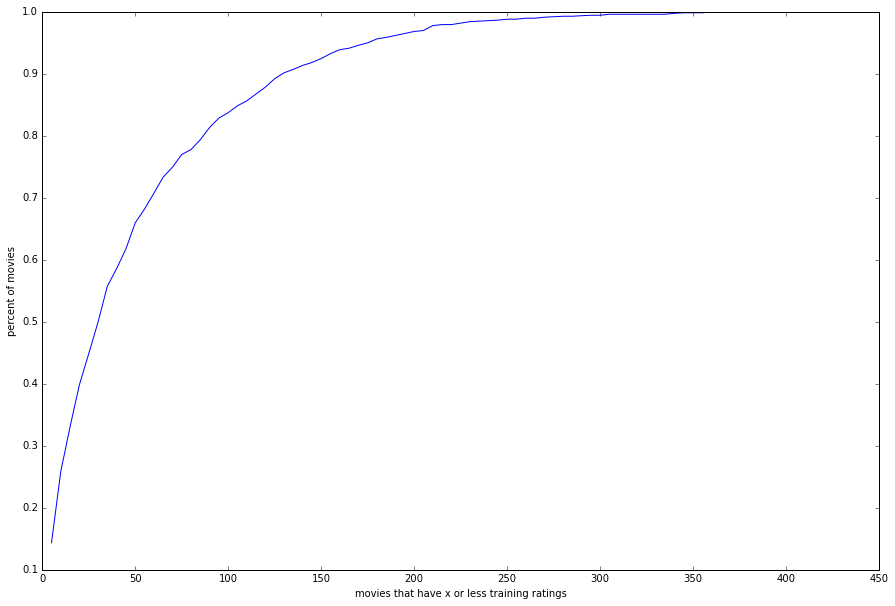

In [38]:
train = pd.read_csv('../data/splits/ml-100k/sparse-item/0.7-train-1.csv')
plot_user_cohort_distribution(train)
plot_movie_cohort_distribution(train)